# Analyzing and Ranking the Turkish Cuisine Restaurants in NYC

### Kadir Egemen Candır
### December, 3, 2019

## 1. Introduction

New York City is one of the largest and most ethnically diverse metropolises in the world. With an estimated 2018 population of 8,398,748 distributed over a land area of about 302.6 square miles (784 km2), New York is also the most densely populated major city in the United States. As the largest city in the United States, it attracts regular international immigration. Approximately 37% of the city's population is foreign born, and more than half of all children are born to mothers who are immigrants. In New York, no single country or region of origin dominates. The ten largest sources of foreign-born individuals in the city as of 2011 were the Dominican Republic, China, Mexico, Guyana, Jamaica, Ecuador, Haiti, India, Russia, and Trinidad and Tobago, while the Bangladeshi-born immigrant population has become one of the fastest growing in the city, counting over 74,000 by 2011.

### 1.1. Background: Turkish Migration to NYC 

The Turkish migration flow to the U.S. is relatively small, with an estimated 400,000 long term emigrants settled in the U.S. between the early 19th century and the early 21st century, and less than 100,000 foreign born Turks in the U.S. today. Since the 1980s, the flow of Turkish immigrants to the United States has included an increasing number of students and professionals as well as migrants who provide unskilled and semi-skilled labor. Thus, in recent years, the highly skilled and educated profile of the Turkish American community has changed with the arrival of unskilled or semi-skilled Turkish labor workers. The unskilled or semi-skilled immigrants usually work in restaurants, gas stations, hair salons, construction sites, and grocery stores, although some of them have obtained American citizenship or green cards and have opened their own ethnic businesses.

The largest concentrations of Turkish Americans are found scattered throughout New York City, Long Island, New Jersey, Connecticut, and other suburban areas. They generally reside in specific cities and neighborhoods including Brighton Beach in Brooklyn, Sunnyside in Queens, and in the cities of Paterson and Clifton in New Jersey. According to the U.S. Census Bureau, in 2000, Americans of Turkish origin mostly live in the State of New York followed by, California, New Jersey, Florida, Texas, Virginia, Illinois, Massachusetts, Pennsylvania, and Maryland. 

The top US communities with the highest percentage of people claiming Turkish ancestry in 2000 are:



### 1.2. Problem: Rising Interest vs Availability of Turkish Cuisine in NYC

As small it may be, the Turkish communities in foreign countries tend to stay loyal to their own cuisine. Prior to the 1980s, the Turkish immigrants in United States used to prepare their own Turkish cuisine food items at their homes and on family, friend gatherings. As the flow of immigration increased after 1980s and especially after 2000s, we have seen increasing number of Turkish cuisine restaurants starting to open in its diverse jewel, New York City.

Data might contribute to determining where Turkish cuisine restaurants are concentrated on which neighborhoods and whether there are neighborhoods that are lacking Turkish cuisine restaurants. Thus, we will be able to provide information on where to stay if they would prefer Turkish couisine. Additionally, the outcome would provide some information on where to invest to open a Turkish cuisine restaurant by outlining scarcity of such businesses. In this project, we will analyze, list and visualize major parts of New York City that has nice Turkish restaurants and provide insights on the findings.

### 1.3. Key objectives of analyzing the data set
<ul>
<li> On which neighborhoods are the best Turkish restaurants?
<li> Which neighborhoods lack Turkish cuisine?
<li> Where to stay to get close to Turkish restaurants?

## 2. Data Acquisition and Cleaning

### 2.1. Data sources

We will use the following data for this project
<ul>
<li> Boroughs, Neighborhoods data of New York City as well as their latitudes and longitudes.
    <ul>
        <li>Source : https://cocl.us/new_york_dataset
    </ul>
<li> Turkish resturants in each neighborhood of NYC.
     <ul>
        <li>Source : Fousquare API
     </ul>
<li> GeoSpace data
     <ul>
        <li>Source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
     </ul>

### 2.2. Methodology
<ul>
<li> We will collect the New York City data from https://cocl.us/new_york_dataset
<li> Using Foursquare API, we will list all venues for each neighborhood
<li> We will filter out the venues that are Turkish restaurants
<li> We will find the ratings, tips and like count for these restaurants using Foursquare API and sort by ratings
<li> We will visualize the ranked neighborhoods using Folium

### 2.2.1. Libraries that will be used
<ul>
<li> Pandas and Numpy for handling the data
<li> Geopy to find coordinates of New York City
<li> Request for using Foursquare API
<li> Folium to visualize the results on the map

In [ ]:
!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge folium=0.5.0 --yes
!conda install -c anaconda beautifulsoup4 

print('Geopy and Folium are downloaded')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim 
import os
import folium 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('All libraries are imported')

All libraries are imported


#### Defining a function to get coordinates, ie, latitudes and longitudes of a given location

In [3]:
def geo_location(address):
    geolocator = Nominatim(user_agent="ege_ny_search")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

#### Defining a function to get New York City's neighborhoods & boroughs along with their latitudes and longitudes

In [4]:
def get_nyc_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    
    # dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # define dataframe
    nyc_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        nyc_data = nyc_data.append({'Borough': borough,
                                  'Neighborhood': neighborhood_name,
                                  'Latitude': neighborhood_lat,
                                  'Longitude': neighborhood_lon}, ignore_index=True)
    
    return nyc_data

#### Defining a function to get data from Foursquare API
<ul>
<li> Radius is set to 1000 meters
<li> Number of venues is limited to 100
</ul>
This function will output venue id, name and category

In [5]:
def get_venues(lat,lng):
    
    #variables are set to the limits defined above
    radius=1000
    LIMIT=100
    CLIENT_ID = '####' # Foursquare ID removed for public GitHub post
    CLIENT_SECRET = '####' # Foursquare Secret removed for public GitHub post
    VERSION = '20180604' 
    
    #Foursquare URL to retreive data
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # Retreiving the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

#### Defining a function to get venue details
<ul>
<li> Details like count, ranking, tip counts etc
<li> This data will be used to rank venues
</ul>

In [6]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '####' # Foursquare ID removed for public GitHub post
    CLIENT_SECRET = '###' # Foursquare Secret removed for public GitHub post
    VERSION = '20180604' 
    
    #Foursquare URL to retreive data
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # Retreiving the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

#### Let's get the New York City data now using get_nyc_data function

In [7]:
nyc_data = get_nyc_data()

#### Quick peek into the data:

In [8]:
nyc_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Let's see how many neighborhoods in New York City

In [9]:
print("There are {} neighborhoods in NYC".format(nyc_data.shape[0]))

There are 306 neighborhoods in NYC


#### Let's plot the data to see some details

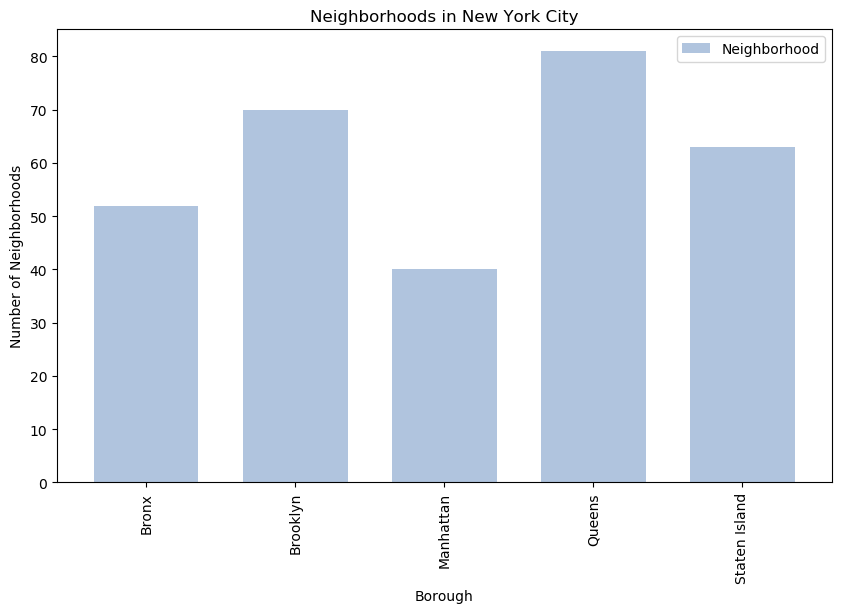

In [76]:
plt.figure(figsize=(10,6), dpi = 100)
plt.title('Neighborhoods in New York City')
plt.xlabel('Borough', fontsize = 10)
plt.ylabel('Number of Neighborhoods', fontsize=10)
nyc_data.groupby('Borough')['Neighborhood'].nunique().plot(kind='bar', color='lightsteelblue', align='center', width=0.7)
plt.legend()
plt.show()

#### Next step is to retreive Turkish restaurants for each neighborhood

In [72]:
col_names=['Borough', 'Neighborhood', 'ID','Name']
turkish_rest_nyc=pd.DataFrame(columns=col_names)
count=1
for row in nyc_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude = row
    venues = get_venues(Latitude,Longitude)
    turkish_resturants=venues[venues['Category']=='Turkish Restaurant']   
    print('(',count,'/',len(nyc_data),')',
          'Turkish Resturants in '+Neighborhood+', '+Borough+':'+str(len(turkish_resturants)))
    for resturant_detail in turkish_resturants.values.tolist():
        id, name , category=resturant_detail
        turkish_rest_nyc = turkish_rest_nyc.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Turkish Resturants in Wakefield, Bronx:0
( 2 / 306 ) Turkish Resturants in Co-op City, Bronx:0
( 3 / 306 ) Turkish Resturants in Eastchester, Bronx:0
( 4 / 306 ) Turkish Resturants in Fieldston, Bronx:0
( 5 / 306 ) Turkish Resturants in Riverdale, Bronx:0
( 6 / 306 ) Turkish Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Turkish Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Turkish Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Turkish Resturants in Norwood, Bronx:0
( 10 / 306 ) Turkish Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Turkish Resturants in Baychester, Bronx:0
( 12 / 306 ) Turkish Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Turkish Resturants in City Island, Bronx:0
( 14 / 306 ) Turkish Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Turkish Resturants in University Heights, Bronx:0
( 16 / 306 ) Turkish Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Turkish Resturants in Fordham, Bronx:0
( 18 / 306 ) Turkish Resturants in East Tremont, Bronx:

#### Let's take a look at the Turkish restaurants dataframe:

In [73]:
turkish_rest_nyc.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Bay Ridge,579d3e7c498effa33c0450af,Istanbul Bay
1,Brooklyn,Gravesend,51a2a2a3498e0d5d337f137b,Wood Spoon
2,Brooklyn,Sheepshead Bay,4fcbfc92e4b088c92e7e97ad,Opera Cafe Lounge
3,Brooklyn,Sheepshead Bay,4b1d5405f964a520d70e24e3,Liman Restaurant
4,Brooklyn,Sheepshead Bay,53800e9c498e1b7adfbaaf5d,Rocca Cafe & Lounge


In [74]:
turkish_rest_nyc.shape

(27, 4)

<i>Looks like there are only 27 Turkish restaurants in New York City. </i>


#### Now let's take a look on how many Turkish restaurants are there in each borough

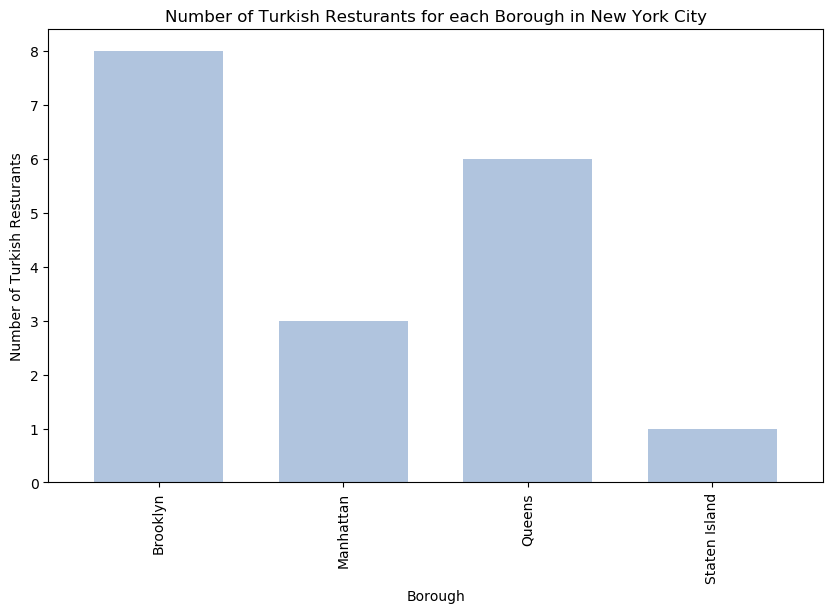

In [58]:
plt.figure(figsize=(10,6), dpi = 100)
plt.title('Number of Turkish Resturants for each Borough in New York City')
plt.xlabel('Borough', fontsize = 10)
plt.ylabel('Number of Turkish Resturants', fontsize=10)
turkish_rest_nyc.groupby('Borough')['ID'].nunique().plot(kind='bar', color='lightsteelblue', align='center', width=0.7)
plt.show()

<i>Brooklyn has the most with 8 out of 27 Turkish restaurants in NYC</i>
#### Now let's take a look on how many Turkish restaurants are there in each neighborhood

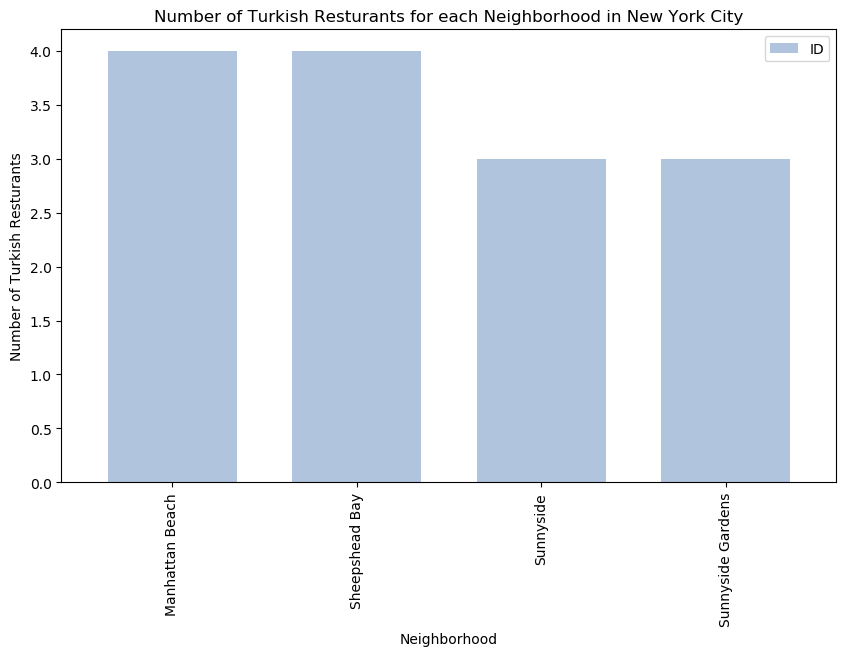

In [77]:
plt.figure(figsize=(10,6), dpi = 100)
plt.title('Number of Turkish Resturants for each Neighborhood in New York City')
plt.xlabel('Neighborhood', fontsize = 10)
plt.ylabel('Number of Turkish Resturants', fontsize=10)
turkish_rest_nyc.groupby('Neighborhood')['ID'].nunique().nlargest(4).plot(kind='bar', color='lightsteelblue', align='center', width=0.7)
plt.legend()
plt.show()

<i>Two neighborhoods: Manhattan Beach and Sheepshead Bay has the most with 4 each. Looks like we'll have to choose between the two neighborhoods. Let's go with Manhattan Beach</i>

In [17]:
turkish_rest_nyc[turkish_rest_nyc['Neighborhood']=='Manhattan Beach']

,Borough,Neighborhood,ID,Name
7,Brooklyn,Manhattan Beach,4b1d5405f964a520d70e24e3,Liman Restaurant
8,Brooklyn,Manhattan Beach,4fcbfc92e4b088c92e7e97ad,Opera Cafe Lounge
9,Brooklyn,Manhattan Beach,53800e9c498e1b7adfbaaf5d,Rocca Cafe & Lounge
10,Brooklyn,Manhattan Beach,4a986cf5f964a520f32b20e3,Istanbul Restaurant Fish & Kebab


#### Let's get the ranking of each restaurant in Manhattan Beach

In [18]:
col_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
turkish_rest_stats_nyc=pd.DataFrame(columns=col_names)
count=1


for row in turkish_rest_nyc.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # if there are no data available, we will assign zero value for these restaurants
        # they may be recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(turkish_rest_nyc),')','processed')
    turkish_rest_stats_nyc = turkish_rest_stats_nyc.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID          Name  Likes  Rating  Tips
0  579d3e7c498effa33c0450af  Istanbul Bay     24     8.2     4
( 1 / 27 ) processed
                         ID        Name  Likes  Rating  Tips
0  51a2a2a3498e0d5d337f137b  Wood Spoon      5     7.1     3
( 2 / 27 ) processed
                         ID               Name  Likes  Rating  Tips
0  4fcbfc92e4b088c92e7e97ad  Opera Cafe Lounge    255     8.2    53
( 3 / 27 ) processed
                         ID              Name  Likes  Rating  Tips
0  4b1d5405f964a520d70e24e3  Liman Restaurant     93     8.4    37
( 4 / 27 ) processed
                         ID                 Name  Likes  Rating  Tips
0  53800e9c498e1b7adfbaaf5d  Rocca Cafe & Lounge    113     7.5    19
( 5 / 27 ) processed
                         ID                              Name  Likes  Rating  \
0  4a986cf5f964a520f32b20e3  Istanbul Restaurant Fish & Kebab     35     7.8   

   Tips  
0    15  
( 6 / 27 ) processed
                         ID        

#### Let's look at the ratings dataframe

In [19]:
turkish_rest_stats_nyc.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Bay Ridge,579d3e7c498effa33c0450af,Istanbul Bay,24,8.2,4
1,Brooklyn,Gravesend,51a2a2a3498e0d5d337f137b,Wood Spoon,5,7.1,3
2,Brooklyn,Sheepshead Bay,4fcbfc92e4b088c92e7e97ad,Opera Cafe Lounge,255,8.2,53
3,Brooklyn,Sheepshead Bay,4b1d5405f964a520d70e24e3,Liman Restaurant,93,8.4,37
4,Brooklyn,Sheepshead Bay,53800e9c498e1b7adfbaaf5d,Rocca Cafe & Lounge,113,7.5,19


In [20]:
turkish_rest_stats_nyc.shape

(27, 7)

In [21]:
turkish_rest_nyc.shape

(27, 4)

<i> Let's save the data into a csv file since there are 500 premium calls per day using Foursquare API. </i>

In [22]:
turkish_rest_stats_nyc.to_csv('turkish_rest_stats_nyc.csv', index=False)

<i>Let's verify the data to ensure match</i>

In [23]:
turkish_rest_stats_nyc_csv=pd.read_csv('turkish_rest_stats_nyc.csv')
turkish_rest_stats_nyc_csv.shape

(27, 7)

In [24]:
turkish_rest_stats_nyc_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Bay Ridge,579d3e7c498effa33c0450af,Istanbul Bay,24,8.2,4
1,Brooklyn,Gravesend,51a2a2a3498e0d5d337f137b,Wood Spoon,5,7.1,3
2,Brooklyn,Sheepshead Bay,4fcbfc92e4b088c92e7e97ad,Opera Cafe Lounge,255,8.2,53
3,Brooklyn,Sheepshead Bay,4b1d5405f964a520d70e24e3,Liman Restaurant,93,8.4,37
4,Brooklyn,Sheepshead Bay,53800e9c498e1b7adfbaaf5d,Rocca Cafe & Lounge,113,7.5,19


<i> Now let's take a look at the turkish_rest_stats_nyc dataframe info </i>

In [25]:
turkish_rest_stats_nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 7 columns):
Borough         27 non-null object
Neighborhood    27 non-null object
ID              27 non-null object
Name            27 non-null object
Likes           27 non-null object
Rating          27 non-null float64
Tips            27 non-null object
dtypes: float64(1), object(6)
memory usage: 1.6+ KB


<i> Likes and tips columns are of string type. These need to be converted into float </i>

In [26]:
turkish_rest_stats_nyc['Likes']=turkish_rest_stats_nyc['Likes'].astype('float64')
turkish_rest_stats_nyc['Tips']=turkish_rest_stats_nyc['Tips'].astype('float64')
turkish_rest_stats_nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 7 columns):
Borough         27 non-null object
Neighborhood    27 non-null object
ID              27 non-null object
Name            27 non-null object
Likes           27 non-null float64
Rating          27 non-null float64
Tips            27 non-null float64
dtypes: float64(3), object(4)
memory usage: 1.6+ KB


#### Identifying the top restaurants

In [27]:
print("Restaurant with most likes:\n", turkish_rest_stats_nyc.iloc[turkish_rest_stats_nyc['Likes'].idxmax()])
print()
print("Restaurant with max rating:\n", turkish_rest_stats_nyc.iloc[turkish_rest_stats_nyc['Rating'].idxmax()])
print()
print("Restaurant with most tips:\n", turkish_rest_stats_nyc.iloc[turkish_rest_stats_nyc['Tips'].idxmax()])

Restaurant with most likes:
 Borough                        Manhattan
Neighborhood             Upper East Side
ID              49eb9b35f964a52001671fe3
Name                             Beyoglu
Likes                                416
Rating                               8.2
Tips                                 178
Name: 14, dtype: object

Restaurant with max rating:
 Borough                        Manhattan
Neighborhood                  Turtle Bay
ID              50fc9a88e4b04cfffaebe2cf
Name                             Sip Sak
Likes                                280
Rating                                 9
Tips                                 100
Name: 23, dtype: object

Restaurant with most tips:
 Borough                        Manhattan
Neighborhood             Upper East Side
ID              49eb9b35f964a52001671fe3
Name                             Beyoglu
Likes                                416
Rating                               8.2
Tips                                 178
Nam

### Visualization

##### First, some preparation
<i> Neighborhoods with maximum average rating of Turkish restaurants</i>

In [28]:
ny_neighborhood_stats=turkish_rest_stats_nyc.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
14,Turtle Bay,9.0
8,Ocean Parkway,8.9
7,Manhattan Terrace,8.9
9,Ravenswood,8.6
11,Steinway,8.6
15,Upper East Side,8.2
3,Dyker Heights,8.2
1,Bay Ridge,8.2
4,Forest Hills Gardens,8.1
16,Upper West Side,8.0


<i> Boroughs with maximum average rating of Turkish restaurants</i>

In [29]:
ny_borough_stats=turkish_rest_stats_nyc.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.400000
2,Queens,8.077778
0,Brooklyn,8.035714
3,Staten Island,0.000000


<i> Since there are no ratings in Staten Island, let's drop it</i>

In [30]:
ny_borough_stats.drop(3, inplace=True)

<i> Let's check the other Borough dataframe to make sure and drop if necessary</i>

In [31]:
turkish_rest_stats_nyc.sort_values(['Rating'],ascending=True).head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
22,Staten Island,Dongan Hills,0,0,0.0,0.0,0.0
1,Brooklyn,Gravesend,51a2a2a3498e0d5d337f137b,Wood Spoon,5.0,7.1,3.0
11,Brooklyn,Bath Beach,4aef96d2f964a5206fd921e3,Istanbul Turkish Fast Food & Restaurant,69.0,7.4,39.0
4,Brooklyn,Sheepshead Bay,53800e9c498e1b7adfbaaf5d,Rocca Cafe & Lounge,113.0,7.5,19.0
9,Brooklyn,Manhattan Beach,53800e9c498e1b7adfbaaf5d,Rocca Cafe & Lounge,113.0,7.5,19.0


In [32]:
turkish_rest_stats_nyc.drop(22, inplace=True)

In [33]:
turkish_rest_stats_nyc.sort_values(['Rating'],ascending=True).head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
1,Brooklyn,Gravesend,51a2a2a3498e0d5d337f137b,Wood Spoon,5.0,7.1,3.0
11,Brooklyn,Bath Beach,4aef96d2f964a5206fd921e3,Istanbul Turkish Fast Food & Restaurant,69.0,7.4,39.0
4,Brooklyn,Sheepshead Bay,53800e9c498e1b7adfbaaf5d,Rocca Cafe & Lounge,113.0,7.5,19.0
9,Brooklyn,Manhattan Beach,53800e9c498e1b7adfbaaf5d,Rocca Cafe & Lounge,113.0,7.5,19.0
26,Queens,Sunnyside Gardens,4b08b328f964a520021123e3,Turkish Grill,51.0,7.7,25.0


In [118]:
turkish_rest_stats_nyc.groupby('Borough').mean()['Rating']

Borough
Brooklyn     8.035714
Manhattan    8.400000
Queens       8.077778
Name: Rating, dtype: float64

### Plotting the average rating of Turkish restaurants for each borough

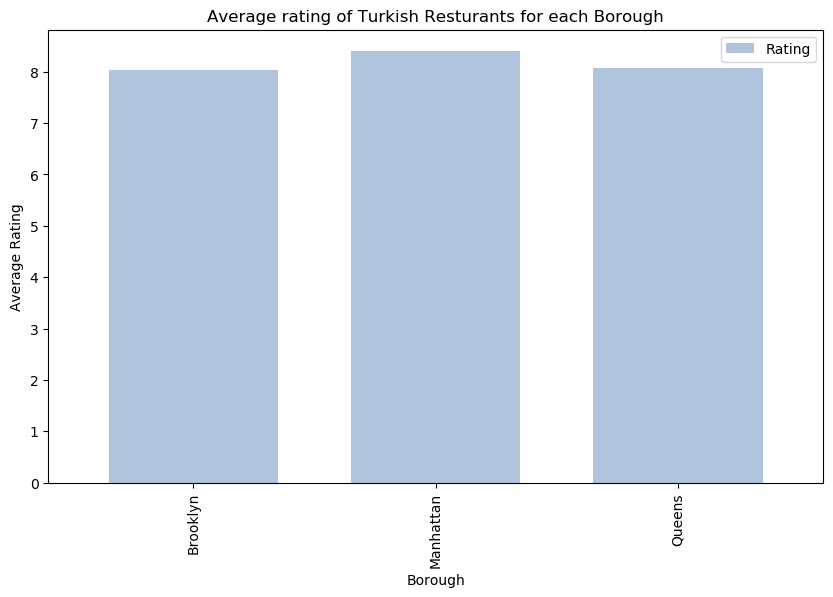

In [34]:
plt.figure(figsize=(10,6), dpi = 100)
plt.title('Average rating of Turkish Resturants for each Borough')
plt.xlabel('Borough', fontsize = 10)
plt.ylabel('Average Rating', fontsize=10)
turkish_rest_stats_nyc.groupby('Borough').mean()['Rating'].plot(kind='bar', color='lightsteelblue', align='center', width=0.7)
plt.legend()
plt.show()

<i>Looks like the average ratings are considerably high so we don't necessarily need to filter out low rated restaurants.</i>
<i>Let's merge this dataset with original NYC dataset to get coordinates in </i>


In [35]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,nyc_data, on='Neighborhood')

In [36]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [37]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bath Beach,40.599519,-73.998752,7.400
1,Brooklyn,Bay Ridge,40.625801,-74.030621,8.200
2,Staten Island,Dongan Hills,40.588673,-74.096399,0.000
3,Brooklyn,Dyker Heights,40.619219,-74.019314,8.200
4,Queens,Forest Hills Gardens,40.714611,-73.841022,8.100
5,Brooklyn,Gravesend,40.595260,-73.973471,7.100
6,Brooklyn,Manhattan Beach,40.577914,-73.943537,7.975
7,Brooklyn,Manhattan Terrace,40.614433,-73.957438,8.900
8,Brooklyn,Ocean Parkway,40.613060,-73.968367,8.900
9,Queens,Ravenswood,40.761705,-73.931575,8.600


#### Now let's form our map

In [38]:
nyc_map = folium.Map(location=geo_location('New York'), zoom_start=11) #create map
feature = folium.map.FeatureGroup() #create feature

#loop through data
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    feature.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, 
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    
#add labels
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(nyc_map) 

#### Here's our map

In [39]:
nyc_map.add_child(feature)

<i> Let's save the map for future use and to reduce the number of runs </i>

In [41]:
nyc_map.add_child(feature).save('turkish_rest_nyc_map.html')

#### Visualizing boroughs based on average rating

<i> Let's get the borough boundaries geojson file ready </i>

In [40]:
borough_map = folium.Map(location=geo_location('New York'), zoom_start=11)
borough_geo = r'Borough Boundaries.geojson'

borough_map.choropleth(
    geo_data=borough_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map and save it into an html file

borough_map.save('turkish_rest_borough_rating.html')

## Results

In this study, we analyzed the Turkish restaurants in one of the most cosmopolitan cities of United States, New York City. The analysis used New York geolocation data and identified Turkish restaurants using Foursquare API. Further analysis was performed on the concentration of the Turkish restaurants on New Yorks boroughs and neighborhoods as well as the ratings of the identified restaurants. 

Our analysis shows that even if there's an increasing number of Turkish people migrating into the United States and especially New York City, the number of Turkish restaurants within the City boundaries are very limited. The number of restaurants identified as Turkish cuisine only came up to be 27 and out of the 27, Brooklyn had the most with 8 restaurants. As can be seen from the map, most restaurants with Turkish cuisine are located near seaside neighborhoods. There are 10 of these restaurants that are distributed between Brooklyn and Staten Island. Manhattan, as the most touristic boroughs of all, has only 3 restaurants that serve Turkish cuisine. 

To sum up the results, we can say that if you'd like to have dinner or lunch at a Turkish restaurant while visiting New York City, you're best off staying either in Brooklyn or Queens. These two neighborhoods host 12 of the 27 Turkish restaurants in New York City. Out of the five boroughs in NYC, Bronx doesn't have any Turkish restaurants. Overall, this analysis shows that most Turkish restaurants are located close to residential boroughs like Brooklyn, Queens and Staten Island than commercial ones like Manhattan. 